In [1]:
import numpy as np
from scipy import special
import matplotlib.pyplot as plt
from scipy.special import factorial as fact
import time

cutoff = 9

In [2]:
def down(order, n):
    n_ = n - order
    n_ = np.clip(n_, 0, None)
    coeff = np.sqrt(fact(n) / fact(n_))
    coeff[(n - order) < 0] = 0
    return [coeff, n_.astype(np.int)]

def up(order, n, cutoff = 10):
    n_ = n + order
    n_[n_ > cutoff] = 0
    coeff = np.sqrt(fact(n_) / fact(n))
    coeff[(n + order) > cutoff] = 0
    return [coeff, n_.astype(np.int)]

def photonNum(order, n, cutoff = 10):
    coeff = n ** order
    return [coeff, n.astype(np.int)]

def to_2d_ndarray(a):
    if isinstance(a,(np.ndarray)):
        return a
    else:
        return np.array([[a]])
    
def Sonin_vec(n, alpha, x):
    n = to_2d_ndarray(n)
    alpha = to_2d_ndarray(alpha)
    x = to_2d_ndarray(x)        
    N = np.max(n)
    a = special.factorial(n + alpha)
    S = np.zeros([N + 1, x.shape[0], x.shape[0], n.shape[0], n.shape[0]], dtype = "float64")
    for i in range(N + 1):
        if i == 0:
            S[0] = 1
        elif i == 1:
            I = np.where(n - i >= 0, 1, 0)
            I = I[np.newaxis, np.newaxis, :, :]
            I_bar = np.logical_not(I).astype("float64")
            S[1] = (alpha + 1 - x) * I + I_bar
        else:
            I = np.where(n - i >= 0, 1, 0)
            I = I[np.newaxis, np.newaxis, :, :].astype("float64")
            I_bar = np.logical_not(I).astype(int)
            res = (2 * i - 1 + alpha - x) * S[i - 1] - (i + alpha - 1) * S[i - 2]
            S[i] = res / i * I + S[i -1] * I_bar
    return S[N]

def FockWignerElement_vec(xmat, pmat, l, m):
    A = np.max(np.dstack([l, m]), axis=2)
    B = np.abs(l - m)
    C = np.min(np.dstack([l, m]), axis=2)
    xmat = xmat[:, :, np.newaxis, np.newaxis]
    pmat = pmat[:, :, np.newaxis, np.newaxis]
    R = xmat**2 + pmat**2
    X = xmat + np.sign(l-m) * 1j * pmat
    W = 2 * (-1)**C * np.sqrt(2**(B) * special.factorial(C) / special.factorial(A)) * X**(B) * np.exp(-R)
    S = Sonin_vec(C, B, 2 * R)
    return W * S

## Multi mode化

prepare multi mode Fock state

In [3]:
modeNum = 3
cutoff = 9
def vacuumState(modeNum, cutoff):
    fockState = np.zeros([(cutoff + 1) ** modeNum])
    fockState[0] = 1
    return fockState.reshape([cutoff + 1] * modeNum)

In [4]:
def singleGate_preProcess(fockState, mode):
    cutoff = fockState.shape[-1] - 1
    fockState = np.swapaxes(fockState, mode, fockState.ndim - 1)
    return fockState.reshape(-1, cutoff + 1)

def twoModeGate_preProcess(fockState, mode1, mode2):
    cutoff = fockState.shape[-1] - 1
    fockState = np.swapaxes(fockState, mode2, modeNum - 1)
    fockState = np.swapaxes(fockState, mode1, modeNum - 2)
    return fockState.reshape(-1, cutoff + 1, cutoff + 1)

def singleGate_postProcess(fockState, mode, modeNum):
    cutoff = fockState.shape[-1] - 1
    fockState = fockState.reshape([cutoff + 1] * modeNum)
    return np.swapaxes(fockState, mode, modeNum - 1)

def twoModeGate_postProcess(fockState, mode1, mode2, modeNum):
    cutoff = fockState.shape[-1] - 1
    fockState = fockState.reshape([cutoff + 1] * modeNum)
    fockState = np.swapaxes(fockState, mode1, modeNum - 2)
    fockState = np.swapaxes(fockState, mode2, modeNum - 1)
    return fockState

def exp_annihiration(fockState, alpha = 1, order = 1, cutoff = 10):
    ind = np.arange(fockState.shape[-1])
    state = np.zeros(fockState.shape) + 0j
    for i in range(cutoff + 1):
        tmp = down(order * i, ind)
        state[:, tmp[1]] += tmp[0] * fockState[:, ind] / fact([i]) * alpha ** i
    return state

def exp_creation(fockState, alpha = 1, order = 1, cutoff = 10):
    ind = np.arange(fockState.shape[-1])
    state = np.zeros(fockState.shape) + 0j
    for i in range(cutoff + 1):
        tmp =  up(order * i, ind, cutoff = cutoff)
        state[:, tmp[1]] += tmp[0] * fockState[:, ind] / fact([i]) * alpha ** i
    return state

def exp_photonNum(fockState, alpha, order = 1, cutoff = 10):
    ind = np.arange(fockState.shape[-1])
    state = np.zeros(fockState.shape) + 0j
    for i in range(cutoff + 1):
        tmp =  photonNum(order * i, ind, cutoff)  # (order, n)
        state[:, tmp[1]] += tmp[0] * fockState[:, ind] / fact([i]) * alpha ** i
    return state

In [5]:
def reduceState(fockState, mode):
    modeNum = fockState.ndim
    cutoff = fockState.shape[-1] - 1
    fockState = np.swapaxes(fockState, mode, 0)
    fockState = fockState.flatten()
    rho = np.outer(np.conj(fockState), fockState)
    for i in range(modeNum - 1):
        rho = partialTrace(rho, cutoff)
    return  rho

def partialTrace(rho, cutoff):
    split = np.int(rho.shape[-1] / (cutoff + 1))
    rho = np.array(np.split(rho, split, axis = -1))
    rho = np.array(np.split(rho, split, axis = -2))
    rho = np.trace(rho, axis1 = -2, axis2 = -1)
    return  rho

In [6]:
def displacement(fockState, mode, alpha, cutoff = 10):
    modeNum = fockState.ndim
    state = singleGate_preProcess(fockState, mode)
    state = exp_annihiration(state, -np.conj(alpha), cutoff = cutoff)
    state = exp_creation(state, alpha, cutoff = cutoff)
    state = singleGate_postProcess(state, mode, modeNum)
    return state * np.exp(-np.abs(alpha)**2 / 2)

### 試してみる

In [7]:
alpha1 = (- 1 + 1j)
mode1 = 1
alpha2 = (1 - 1j)
mode2 = 2
modeNum = 3
cutoff = 10
fockState = vacuumState(modeNum, cutoff)
state = displacement(fockState, mode1, alpha1, cutoff)
state = displacement(state, mode2, alpha2, cutoff)
# reducedState0 = reduceState(state, 0)
# reducedState1 = reduceState(state, 1)
# reducedState2 = reduceState(state, 2)

# print(reducedState0)
# print(reducedState1)
# print(reducedState2)

In [8]:
def FockWigner_vec(xmat, pmat, fockState, mode, tol=1e-10):
    if fockState.ndim < mode + 1:
        raise  ValueError("The mode is not exist.")
    if fockState.ndim > 1:
        rho = reduceState(fockState, mode)
    else:
        rho = np.outer(np.conj(fockState), fockState)
    dim = len(fockState)
    grid = np.indices([dim, dim])
    W = FockWignerElement_vec(xmat, pmat, grid[0], grid[1])
    W = rho * W
    W = np.sum(np.sum(W, axis = -1), axis = -1)
    if np.max(np.imag(W)) < tol:
        W = np.real(W)
    else:
        raise ValueError("Wigner plot has imaginary value.")
    return W

0.33687686920166016


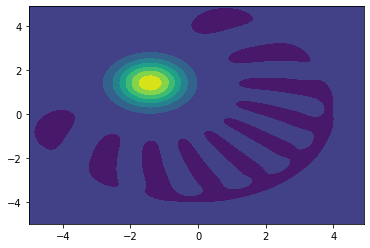

In [9]:
x = np.arange(-5, 5, 0.1)
p = np.arange(-5, 5, 0.1)
m = len(x)
xx, pp = np.meshgrid(x, p)
xi_array = np.dstack((pp, xx))
start = time.time()
        
W = FockWigner_vec(xx, pp, state, 1)

h = plt.contourf(x, p, W)
t = time.time() - start
print(t)

### Beam Splitter

$\hat{H} = i\hbar \theta (\hat{a}_{1}^{\dagger}\hat{a}_{2} -\hat{a}_{1}  \hat{a}_{2}^{\dagger})$

$BSgate = \exp(\frac{i}{\hbar}\hat{H})$

In [10]:
def ab_ba(fockState, cutoff):
    state = np.zeros(fockState.shape) + 0j
    dim = cutoff + 1
    a = np.arange(dim) * np.ones([dim, dim])
    ind1 = np.ravel(a, order = 'F').astype(np.int)
    ind2 = np.ravel(a, order = 'K').astype(np.int)
    coef =  fockState[:, ind1, ind2]
    down1 = down(1, ind1)
    up2 = up(1, ind2, cutoff)
    state[:, down1[1], up2[1]] -= down1[0] * up2[0] * coef

    up1 = up(1, ind1, cutoff)
    down2 = down(1, ind2)
    state[:, up1[1], down2[1]] += up1[0] * down2[0] * coef
    return state

def pow_ab_ba(fockState, n, cutoff):
    state = np.copy(fockState)
    if n == 0:
        return state
    else:
        for i in range(n):
            state = ab_ba(state, cutoff)
        return state

def exp_BS(fockState, alpha, cutoff):
    state = np.zeros(fockState.shape) + 0j
    for i in range(2 * cutoff + 1): # order
        tmpstate = np.copy(fockState)
        tmpstate = pow_ab_ba(tmpstate, i, cutoff)
        tmpstate = tmpstate / special.factorial([i]) * alpha ** i
        state += tmpstate
    return state

In [11]:
def BS(fockState, mode1, mode2, theta, cutoff):
    modeNum = fockState.ndim
    if modeNum < 2:
        raise ValueError("The gate requires more than one mode.")
    state = twoModeGate_preProcess(fockState, mode1, mode2)
    state = exp_BS(state, -theta, cutoff)
    state = twoModeGate_postProcess(state, mode1, mode2, modeNum)
    return state

In [45]:
alpha = (1 + 1j)
mode = 2
modeNum = 3
cutoff = 15
start = time.time()
state = vacuumState(modeNum, cutoff)
state = displacement(state, mode, alpha, cutoff)
print(np.sum(np.abs(state)**2))
state2 = BS(state, 1, 2, np.pi / 4, cutoff)
print(np.sum(np.abs(state2)**2))
t = time.time() - start
print(t)

0.999999999520031
0.9999999995200984
0.1696791648864746


1.3069140911102295


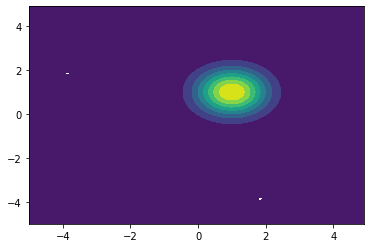

In [48]:
x = np.arange(-5, 5, 0.1)
p = np.arange(-5, 5, 0.1)
m = len(x)
xx, pp = np.meshgrid(x, p)
xi_array = np.dstack((pp, xx))
start = time.time()
        
W1 = FockWigner_vec(xx, pp, state2, 2)

h = plt.contourf(x, p, W1)
t = time.time() - start
print(t)

## For Check

In [34]:
import sys
sys.path.append('../')

import photonqat as pq
import strawberryfields as sf
from strawberryfields.ops import *

In [42]:
G = pq.Gaussian(3)
#G.Displace(0, alpha) # Displacement gate, x to x+2
G.Displace(2, alpha) # Displacement gate, x to x+2
G.BS(1, 2, np.pi/4) # 50:50 beam splitter

print('mu0 =', G.mean(0))
print('mu1 =', G.mean(1))
print('mu2 =', G.mean(2))

mu0 = [0. 0.]
mu1 = [1. 1.]
mu2 = [-1. -1.]


In [49]:
eng = sf.Engine(backend="gaussian")
gaussian = sf.Program(3)

with gaussian.context as q:
        sf.hbar = 1
        # prepare the initial states
        Dgate(alpha) | q[2] # displacement gate
        BSgate(np.pi/4, 0) | (q[1], q[2])  # 50-50 beamsplitter


results = eng.run(gaussian)
mu0, cov0 = results.state.reduced_gaussian([0])
mu1, cov1 = results.state.reduced_gaussian([1])
mu2, cov2 = results.state.reduced_gaussian([2])
print('mu0 =', mu0)
print('mu1 =', mu1)
print('mu2 =', mu2)

mu0 = [0. 0.]
mu1 = [-1. -1.]
mu2 = [1. 1.]


Generate beamsplitter factors in the Fock basis.

This function generates the beamsplitter prefactors,

$ prefac_{N,n,M,m,k} = (-1)^{N-k}\sqrt{binom(n,k)binom(m,N-k)binom(N,k)binom(M,n-k)}$

for a specific cutoff dimension $D$.

Note that the last dimension will only contain non-zero values
for indices $0$ to $n$

Args:
D (int): generate prefactors for $D$ dimensions.